# 📚 **Word2Vec Baseline 구현하기** 👩‍💻
* brown_new 다운로드 및 정제는 [여기](https://towardsdatascience.com/understanding-word2vec-embedding-in-practice-3e9b8985953)를 참고하였습니다.
* word2vec 모델 구현이 목적이므로 데이터 전처리 (불용어 제거,토큰화)는 패키지의 도움을 받았습니다.
* [mxnet으로 구현한 skip gram](https://nbviewer.jupyter.org/url/courses.d2l.ai/berkeley-stat-157/slides/4_18/word2vec-gluon.ipynb)과 [torch로 구현한 CBOW](https://rguigoures.github.io/word2vec_pytorch/)에서 힌트를 얻었습니다 !

In [ ]:
import nltk
import re, string, spacy
from urllib import request
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import torch
import random
import time

import matplotlib.pyplot as plt

# ⛳ **Negative sampling**
주어진 확률로 빠르게 sampling을 하기 위한 여러가지 방법을 비교합니다.

In [ ]:
# 임의로 100개의 확률값을 생성

weight = [random.randint(0,1000) for _ in range(100)]
prob = [w/sum(weight) for w in weight]

# binary search를 위한 cumulative prob 계산
cum_prob = [0]*(len(prob)+1)
for i in range(1,len(cum_prob)):
    cum_prob[i] = cum_prob[i-1] + prob[i-1]
del cum_prob[0]

prob = torch.tensor(prob)

In [ ]:
print('방법 1. 비복원 추출로 5개씩 10000번')
start = time.time()
res1 = []
for _ in range(10000):
    res1.extend(torch.multinomial(prob, 5, replacement = False).tolist())
print(f">> {time.time()-start:.3f}")

print('방법 2. 복원 추출로 5000개씩 10번')
start = time.time()
res2 = []
for _ in range(10):
    res2.extend(torch.multinomial(prob, 5000, replacement = True).tolist())
print(f">> {time.time()-start:.3f}")

import bisect
print('방법 3. uniform + binary search로 50000번')
start = time.time()
res3 = []
for _ in range(50000):
    next_random = random.uniform(0,1)
    res3.append(bisect.bisect_left(cum_prob, next_random))
print(f">> {time.time()-start:.3f}")

방법 1. 비복원 추출로 5개씩 10000번
>> 0.444
방법 2. 복원 추출로 5000개씩 10번
>> 0.004
방법 3. uniform + binary search로 50000번
>> 0.030


In [ ]:
from collections import Counter

def get_freq(results):
    c = Counter(results)
    return c.keys(), c.values()

## **sampling 결과를 이용해서 세 방법 비교하기**
모두 기댓값에 근사하도록 sample이 추출되었음을 확인할 수 있다. 가장 빠르게 추출할 수 있는 방법 2를 선택하여 구현한다.

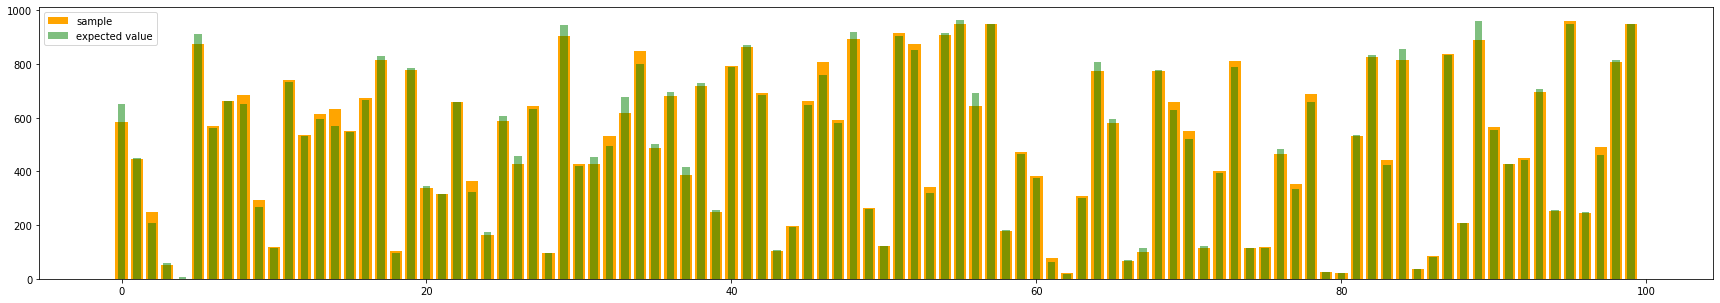

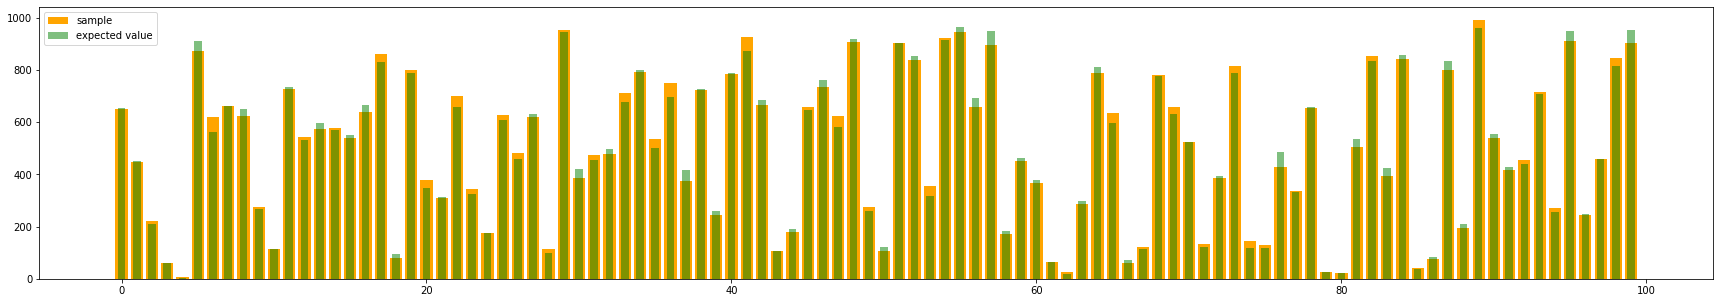

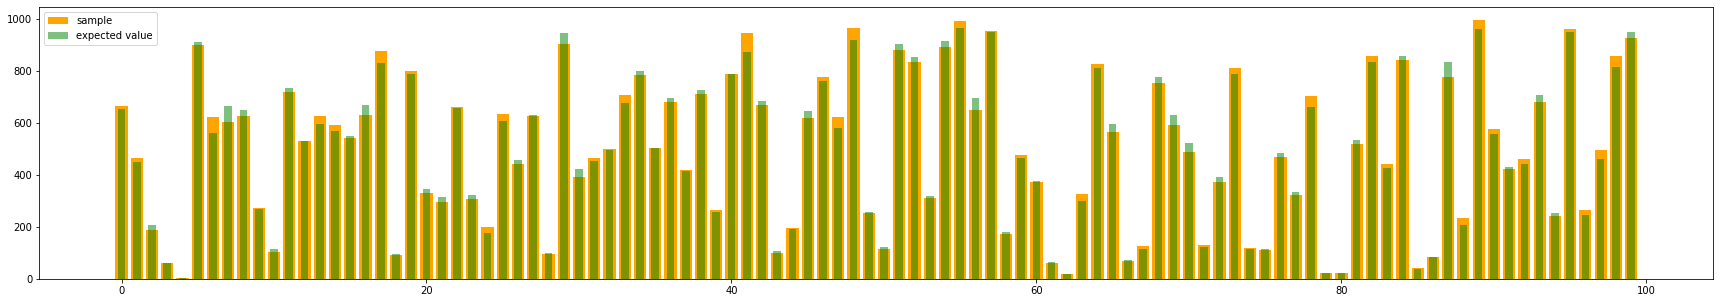

In [ ]:
for res in [res1, res2, res3]:
    plt.figure(figsize = (30,5))
    plt.bar(*get_freq(res), width = 0.8, color = 'orange',label = 'sample')
    plt.bar(range(100), [p*50000 for p in prob], width = .5, color = 'green', alpha = 0.5, label = 'expected value')
    plt.legend()
    plt.show()

# 📓 **ExampleDownloader, Vocabulary**
다음 두가지 class를 정의합니다.
* `ExampleDownloader` brown corpus를 다운받고 기본 text 정제한다.
* `Vocabulary` skip-gram 학습용 데이터 형태를 생성. (subsampling 후 center-context 형태로)

In [ ]:
from collections import Counter
from itertools import chain
import zipfile
import os
import random

class ExampleDownloader:
    def __init__(self, dir):
        self.dir = dir
        self.stopwords = stopwords.words('english')
        self.nlp = spacy.load('en', disable=['ner', 'parser'])

        print("*** Download ***")
        self.download_dataset()
        print("*** Cleaning Data ***")
        self.cleaning_data()
    
    def download_dataset(self):

        if 'bbc-text.csv' not in os.listdir():
            filename,_ = request.urlretrieve('https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv', self.dir+'bbc-text.csv')
        with open('bbc-text.csv', 'r') as f:
            data = f.read()
        self.raw_data = re.split('\n\w+?,',data)[1:]

    def _clean_text(self,text):
        text = text.lower() # 소문자로 변환
        text = re.sub(r'\[.*?\]', '', text) # 대괄호에 묶인 단어 제거
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # 구두점 제거
        text = re.sub(r'\w*\d\w*', '', text) # 숫자 제거

        doc = self.nlp(text)
        text = " ".join([word.lemma_ for word in doc])
        text = text.replace('-PRON-', '')

        return [i for i in text.split() if i not in self.stopwords]

    def cleaning_data(self):
        self.raw_data = [self._clean_text(line) for line in self.raw_data]

In [ ]:
class Vocabulary:
    def __init__(self, data, max_vocab_size = -1, min_counts = 200, window_size = 2):
        """
        Skip gram을 위한 vocab과 dataset을 생성
        freq (counter) : word to frequency
        vocab (dict) : word to index
        context (list) : [ [ center, [context] ], ... ]
        """
        self.raw_data = data
        self.max_vocab_size = max_vocab_size
        self.min_counts = min_counts
        self.window_size = window_size

        print("*** Build Vocabulary ***")
        self._get_frequency_and_vocab()

        print("*** Subsampling ***")
        self.subsampling()

        print("*** Build Context set ***")
        self.build_context_set()

    def _get_frequency_and_vocab(self):
        most_common = Counter(chain.from_iterable(self.raw_data)).most_common()
        if self.max_vocab_size > 0:
            most_common = most_common[:self.max_vocab_size]
        most_common_words = [word for word, count in most_common if count >= self.min_counts]

        self.freq = {word:0 for word in most_common_words}
    
        filtered_data = []
        for line in self.raw_data:
            tmp = []
            for word in line:
                if self.freq.get(word) is None:
                    continue
                self.freq[word] += 1
                tmp.append(word)
            filtered_data.append(tmp)
        self.raw_data = filtered_data

        self.freq = Counter(self.freq)
        vocab = [i for i,j in self.freq.most_common()]
        self.vocab = dict(zip(vocab, range(len(vocab)))) # 가장 많이 등장한 단어의 index가 0이 되도록

        self.vocab_size = len(self.vocab)

        print("> Vocab size :",self.vocab_size)
        print('> Most common words :', self.freq.most_common(10))

    def _get_drop_prob(self):
        total = sum(self.freq.values())
        drop_prob = lambda x: max(0, 1-(1e-4/x)**(1/2))
        self.drop_rate = {word:drop_prob(freq/total) for word, freq in self.freq.items()}

    def _drop_this_word(self, word):
        # uniform(0,1)에서 sample하나를 뽑고 keep prob와 비교하여 keep하거나 remove
        return random.uniform(0,1) < self.drop_rate[word]

    def subsampling(self):
        self._get_drop_prob()

        subsampling = []
        for line in self.raw_data:
            tmp = []
            for word in line:
                if not self._drop_this_word(word):
                    tmp.append(word)
            subsampling.append(tmp)
        self.data = subsampling

    def build_context_set(self): # (중심 단어, (주변 단어1, 주변 단어1)), (중심단어, (주변 단어1, 주변 단어 2, ...)
        self.center = []
        self.context = []
        for line in self.data:
            if len(line) < 2:
                continue
            for i in range(len(line)): # center가 i일 때
                context = []
                center = line[i]
                for j in range(i-self.window_size, i+self.window_size+1):
                    if j < 0 or j >= len(line) or j == i:
                        continue
                    context.append(self.vocab[line[j]])
                if context:
                    self.context.append(context)
                    self.center.append([self.vocab[center]])

        print('> pairs of target and context words :', len(self.context))
        print("> Center examples :",self.center[:5])
        print("> Context examples :",self.context[:5]) 

In [ ]:
example = ExampleDownloader(dir = '')

*** Download ***
*** Cleaning Data ***


In [ ]:
vocab = Vocabulary (example.raw_data, max_vocab_size = -1 , min_counts = 10, window_size = 3 )

*** Build Vocabulary ***
> Vocab size : 5377
> Most common words : [('say', 8839), ('mr', 3003), ('year', 2829), ('would', 2664), ('make', 2222), ('also', 2156), ('people', 2044), ('new', 1987), ('one', 1809), ('take', 1746)]
*** Subsampling ***
*** Build Context set ***
> pairs of target and context words : 219972
> Center examples : [[368], [945], [67], [968], [4060]]
> Context examples : [[945, 67, 968], [368, 67, 968, 4060], [368, 945, 968, 4060, 2038], [368, 945, 67, 4060, 2038, 2831], [945, 67, 968, 2038, 2831, 1187]]


## 📊 **subsampling의 효과 확인하기**
**line당 token수 감소**
기존에는 1000개가 넘는 경우도 존재했으나 subsampling 후 전반적으로 감소한 것을 확인할 수 있다.

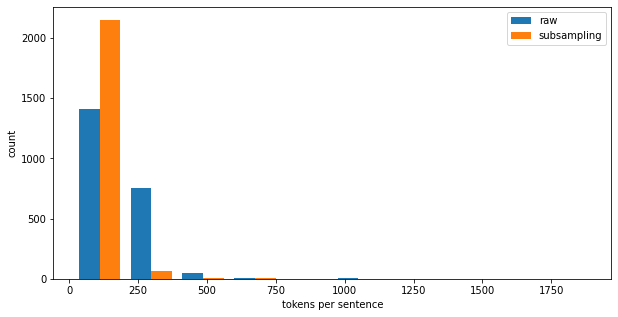

In [ ]:
import matplotlib.pyplot as plt

# 기존에는 line당 token 수가 800 이상도 있었으나 subsampling후 sequence의 길이가 전반적으로 감소하였다.

raw = [len(line) for line in vocab.raw_data]
sub = [len(line) for line in vocab.data]

plt.figure(figsize = (10,5))
plt.hist([raw,sub], label = ['raw','subsampling'])
plt.legend(loc = 'upper right')
plt.xlabel('tokens per sentence')
plt.ylabel('count')
plt.show()

**자주 등장했던 단어가 기존 빈도의 10% 수준으로 떨어진다.**
say, mr, year 등 자주 등장했던 단어는 기존의 0.1배로, 중간~자주 등장하지 않은 단어는 기존의 0.9배 혹은 1배로 변화한다.

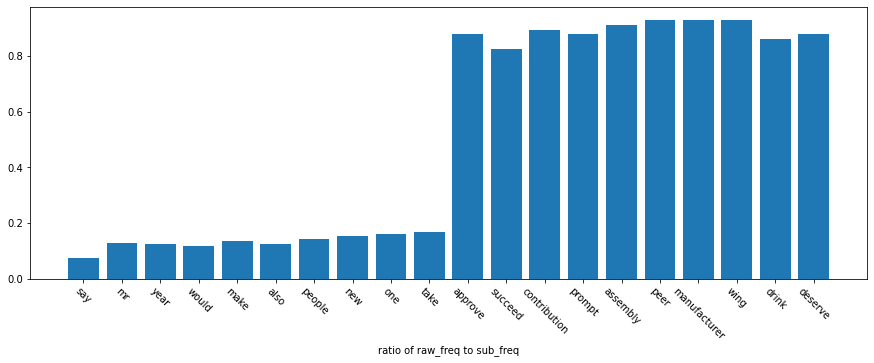

In [ ]:
most_common = vocab.freq.most_common(10)
rare = vocab.freq.most_common()[1500:1510]

words, raw_freq = zip(*most_common+rare)

counter_subsampling = Counter(chain.from_iterable(vocab.data))
sub_freq = [counter_subsampling[word] for word in words]

plt.figure(figsize = (15,5))
plt.bar(words,[sub/raw for raw,sub in  zip(raw_freq,sub_freq)])
plt.xticks(rotation = -45)
plt.xlabel('ratio of raw_freq to sub_freq')
plt.show()

물론 subsampling을 하더라도 여전히 하위 단어에 비해 더 많이 포함되어있다.

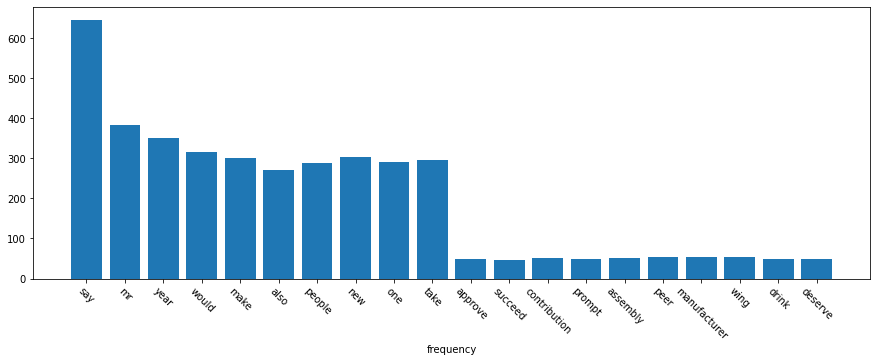

In [ ]:
plt.figure(figsize = (15,5))
plt.bar(words,sub_freq)
plt.xticks(rotation = -45)
plt.xlabel('frequency')
plt.show()

# 🏰 **Skip Gram**
`Vocabulary`의 object를 받아 negative sampling을 진행하고 batch 형태로 쪼갭니다.  
`self.get_similar_word`를 통해 유사한 단어를 추출합니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.metrics.pairwise import cosine_similarity

class SkipGram(nn.Module):
    def __init__(self,vocabulary, hidden_size = 200 , negative_sample_size = 5 ,batch_size = 200, padding_idx = 0):
        super(SkipGram, self).__init__()
        self.center, self.context = vocabulary.center, vocabulary.context
        self.freq = vocabulary.freq
        self.vocab_size = vocabulary.vocab_size
        self.word_to_idx = vocabulary.vocab
        self.idx_to_word = {j:i for i,j in self.word_to_idx.items()}

        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.negative_sample_size = negative_sample_size
        self.padding_idx = padding_idx
        self.neg_candidates = []

        print('*** Negative sampling ***')
        self.negative_sampling()

        print('*** Batchify ***')
        self.batchify()

        self.U = nn.Embedding(self.vocab_size, self.hidden_size)
        self.V = nn.Embedding(self.vocab_size, self.hidden_size)
    
    def _cal_negative_sampling_prob(self):
        sampling_weight = lambda x: x**(0.75)
        self.negative_sampling_prob = []
        for i in range(self.vocab_size):
            word = self.idx_to_word[i]
            self.negative_sampling_prob.append(sampling_weight(self.freq[word]))
        self.negative_sampling_prob = torch.tensor(self.negative_sampling_prob)

    def _get_negative_sample(self):
        if len(self.neg_candidates) == 0:
            self.neg_candidates = torch.multinomial(self.negative_sampling_prob, 10000,replacement = True).tolist()
        return self.neg_candidates.pop()

    def negative_sampling(self):
        self._cal_negative_sampling_prob()
        self.negative_samples = []

        for i in range(len(self.center)):
            negative_ids = [self.center[i]] + self.context[i]
            remove_soon = len(negative_ids)
            while len(negative_ids) < self.negative_sample_size + remove_soon:
                neg = self._get_negative_sample()
                if neg in negative_ids:
                    continue
                negative_ids.append(neg)
            negative_ids = negative_ids[remove_soon:]
            self.negative_samples.append(negative_ids)

        print('> Negative sample :',self.negative_samples[:5])   
    
    def batchify(self):
        self.batch = []

        for start in range(0, len(self.center), self.batch_size):
            center_batch = self.center[start:start+self.batch_size]
            context_neg_batch = self.context[start:start+self.batch_size]
            label_batch = []
            mask_batch = []

            max_len = max(len(c) for c in context_neg_batch) + self.negative_sample_size

            for i in range(len(center_batch)):
                context_length = len(context_neg_batch[i])
                context_neg_batch[i].extend(self.negative_samples[start+i])

                padding_length = max_len - context_length - self.negative_sample_size
                context_neg_batch[i] += [self.padding_idx]*padding_length

                # label = [1.]*(context_length) + [-1.]*self.negative_sample_size + [0.]*padding_length
                label = [1.]*(context_length) + [0.]*self.negative_sample_size + [0.]*padding_length
                # label = [[i] for i in label]
                mask = [1.]*(context_length + self.negative_sample_size) + [0.]*padding_length
                # mask = [[i] for i in mask]

                label_batch.append(label)
                mask_batch.append(mask)

            self.batch.append([torch.tensor(center_batch), torch.tensor(context_neg_batch)
                                , torch.tensor(label_batch), torch.tensor(mask_batch)])
             
        print('> Batch (center)      :', self.batch[0][0].shape)
        print('> Batch (context_neg) :', self.batch[0][1].shape)
        print('> Batch (label)       :', self.batch[0][2].shape)
        print('> Batch (mask)        :', self.batch[0][3].shape)

    def forward(self,center_ids, context_neg_ids):

        center_embedding = self.U(center_ids)
        context_neg_embedding = self.V(context_neg_ids) # (batch_size, max_len , hidden_size)

        center_embedding_t = center_embedding.transpose(1,2) # (batch_size, hidden_size, 1)
        dot_product = torch.bmm(context_neg_embedding,center_embedding_t) # pairwise dot product

        # return dot_product
        return dot_product.squeeze(2)

    def get_similar_word(self, query):
        W = self.U.weight
        x = W[self.word_to_idx[query]]
        
        cos = torch.matmul(W, x) / ( torch.sum(W * W, axis=1) * torch.sum(x * x) + 1e-9).sqrt()

        topk = cos.argsort()[-10:].tolist()[::-1]

        for i in topk[1:]:  # Remove the input words
            print(round(float(cos[i]),3), self.idx_to_word[i],end = ' / ')

        return topk

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
vocab = Vocabulary (example.raw_data, max_vocab_size = -1 , min_counts = 30, window_size = 3 )
model = SkipGram(vocabulary = vocab, hidden_size = 50, negative_sample_size = 5 ,batch_size = 512, padding_idx = 0)

cuda
*** Build Vocabulary ***
> Vocab size : 2462
> Most common words : [('say', 8839), ('mr', 3003), ('year', 2829), ('would', 2664), ('make', 2222), ('also', 2156), ('people', 2044), ('new', 1987), ('one', 1809), ('take', 1746)]
*** Subsampling ***
*** Build Context set ***
> pairs of target and context words : 162031
> Center examples : [[191], [968], [1138], [172], [2038]]
> Context examples : [[968, 1138, 172], [191, 1138, 172, 2038], [191, 968, 172, 2038, 47], [191, 968, 1138, 2038, 47, 6], [968, 1138, 172, 47, 6, 116]]
*** Negative sampling ***
> Negative sample : [[101, 792, 7, 1455, 34], [896, 107, 364, 2355, 987], [188, 753, 241, 1627, 208], [356, 1262, 5, 179, 953], [1136, 692, 147, 863, 244]]
*** Batchify ***
> Batch (center)      : torch.Size([512, 1])
> Batch (context_neg) : torch.Size([512, 11])
> Batch (label)       : torch.Size([512, 11])
> Batch (mask)        : torch.Size([512, 11])


# 🏃‍♀ **Train**

In [ ]:
model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr = 0.05)

for ep in range(3):
    i = 0
    for center_ids, context_neg_ids, label, mask in model.batch:
        optimizer.zero_grad()
        dot_product = model.forward(center_ids.to(device), context_neg_ids.to(device))
        
        # reduction = 'mean(default)'은 batch_size*class 갯수로 나눠짐. mask 고려해야할거같은데..
        Bceloss = nn.BCEWithLogitsLoss(mask.to(device))
        l = Bceloss(dot_product, label.to(device))

        l.backward()
        optimizer.step()

        if i%200 == 0:
            print(l)
        i += 1

    print(f"{ep} 끗 ***********")

tensor(2.8684, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8542, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
0 끗 ***********
tensor(0.6513, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6865, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
1 끗 ***********
tensor(0.6401, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6863, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
2 끗 ***********


# 👀 **유사한 단어 탐색**

In [ ]:
model.to('cpu')
model.eval()

for center in ['digital','military','technology','economic']:
    print(center)
    model.get_similar_word(center)
    print()

digital
1.0 digital / 0.565 mobile / 0.5 image / 0.499 tv / 0.494 sensitive / 0.488 music / 0.486 bt / 0.484 las / 0.463 audio / 0.459 hundred / 
military
1.0 military / 0.437 ordinary / 0.434 representative / 0.429 cabinet / 0.421 map / 0.407 japan / 0.406 send / 0.402 importance / 0.401 across / 0.39 crime / 
technology
1.0 technology / 0.699 use / 0.621 developer / 0.62 intel / 0.588 giant / 0.563 sensitive / 0.536 mac / 0.523 image / 0.511 innovation / 0.494 source / 
economic
1.0 economic / 0.628 debt / 0.538 employment / 0.536 export / 0.491 fuel / 0.489 domestic / 0.486 aircraft / 0.473 spending / 0.473 enjoy / 0.472 transport / 
